In [41]:
from evaluation import regression_evaluator
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [3]:
data = pd.read_csv("fourth_down_dataset.csv")
print(data['play_type'].value_counts())
data.head()

play_type
punt          13390
field_goal     5762
pass           2694
run            1608
no_play        1364
qb_kneel         20
Name: count, dtype: int64


,year,week,yardline_100,half_seconds_remaining,game_seconds_remaining,drive,ydstogo,ydsnet,play_type,no_huddle,...,drive_play_count,spread_line,posteam_is_home,posteam_spread_line,wpa_avg,wp_avg,is_reg_season,wp_difference,posteam_rush_epa_per_sec,posteam_pass_epa_per_sec
0,2023,1,49.0,1568.0,3368.0,1.0,7.0,26.0,punt,0.0,...,8.0,7.0,True,7.0,0.019394,0.591893,True,0.191468,0.000576,-0.007523
1,2023,1,70.0,1365.0,3165.0,2.0,8.0,13.0,punt,0.0,...,6.0,7.0,False,-7.0,0.025689,0.362001,True,0.141623,-0.003831,0.002626
2,2023,1,11.0,956.0,2756.0,4.0,9.0,64.0,field_goal,0.0,...,8.0,7.0,False,-7.0,0.015591,0.254729,True,0.116695,0.000312,-0.004110
3,2023,1,36.0,811.0,2611.0,6.0,9.0,1.0,field_goal,0.0,...,4.0,7.0,False,-7.0,0.015624,0.315264,True,0.136998,-0.000975,0.001082
4,2023,1,85.0,384.0,2184.0,8.0,11.0,-1.0,punt,0.0,...,3.0,7.0,False,-7.0,-0.037780,0.333675,True,0.114554,0.002215,-0.000167


In [4]:
def partition(data, play_type="pass"):
    return data[data['play_type'] == play_type].drop('play_type', axis=1)

passing = partition(data,'pass')
run = partition(data,'run')
fg = partition(data,'field_goal')
punt = partition(data,'punt')

In [5]:
y = run['wpa_avg'].to_numpy()
X = run.drop('wpa_avg', axis=1)
cols = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
xg = xgb.XGBRegressor(objective='reg:squarederror')
sel_xg = SelectFromModel(xg, threshold='median')
sel_xg.fit(X_train, y_train)

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='reg:pseudohubererror', ...),
                threshold='median')

In [7]:
param_grid = {
        'eta': [0.065, .07, 0.075],
        'n_estimators': [500, 600,700,800],
        'max_depth': [2,3,4, 5],
        'huber_slope': [0.09]
}


In [8]:
cols = X_train.columns[(sel_xg.get_support())]
re = regression_evaluator(col_names=cols)
X_train_sel = X_train[cols]
X_test_sel = X_test[cols]

In [9]:
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X_train, y_train) 

best_params = grid_search.best_params_
print(best_params)

best_xg_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=500; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=500; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=500; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=500; total time=   0.3s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=500; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=600; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=600; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=600; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=600; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estimators=600; total time=   0.2s
[CV] END eta=0.065, huber_slope=0.09, max_depth=2, n_estim

[CV] END eta=0.07, huber_slope=0.09, max_depth=2, n_estimators=700; total time=   0.2s
[CV] END eta=0.07, huber_slope=0.09, max_depth=2, n_estimators=700; total time=   0.3s
[CV] END eta=0.07, huber_slope=0.09, max_depth=2, n_estimators=800; total time=   0.4s
[CV] END eta=0.07, huber_slope=0.09, max_depth=2, n_estimators=800; total time=   0.2s
[CV] END eta=0.07, huber_slope=0.09, max_depth=2, n_estimators=800; total time=   0.2s
[CV] END eta=0.07, huber_slope=0.09, max_depth=2, n_estimators=800; total time=   0.3s
[CV] END eta=0.07, huber_slope=0.09, max_depth=2, n_estimators=800; total time=   0.3s
[CV] END eta=0.07, huber_slope=0.09, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END eta=0.07, huber_slope=0.09, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END eta=0.07, huber_slope=0.09, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END eta=0.07, huber_slope=0.09, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END eta=0.07, huber_slope=0.09, max_de

[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=600; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=600; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=600; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=700; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=700; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=700; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=700; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=700; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=800; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=800; total time=   0.3s
[CV] END eta=0.075, huber_slope=0.09, max_depth=3, n_estimators=800; total time=   0.4s
[CV] END eta=0.075, huber_slope=

Evaluation for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.075, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None, huber_slope=0.09,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, ...) (Train)
Max Error: 0.049278427560253135
Mean Absolute Error: 0.004818285955251152
Mean Squared Error: 5.146810771458458e-05
Root Mean Squared Error: 0.007174127662272577
R-Squared: 0.9907231559495171
Mean Squared Error for +wpa: 3.706390882367168e-05
Mean 

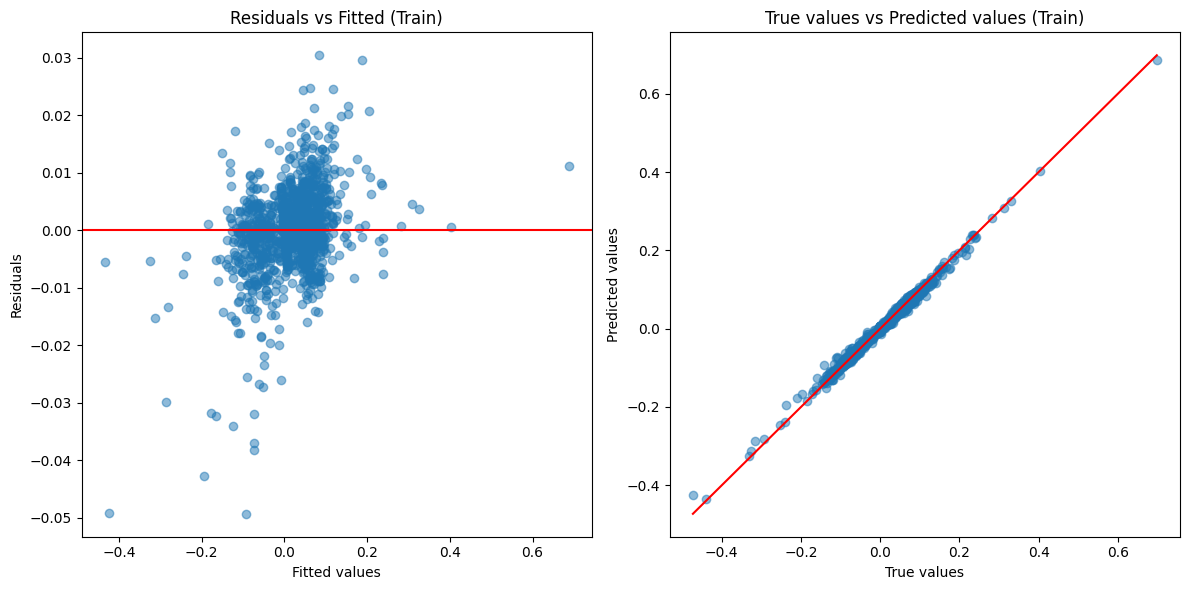

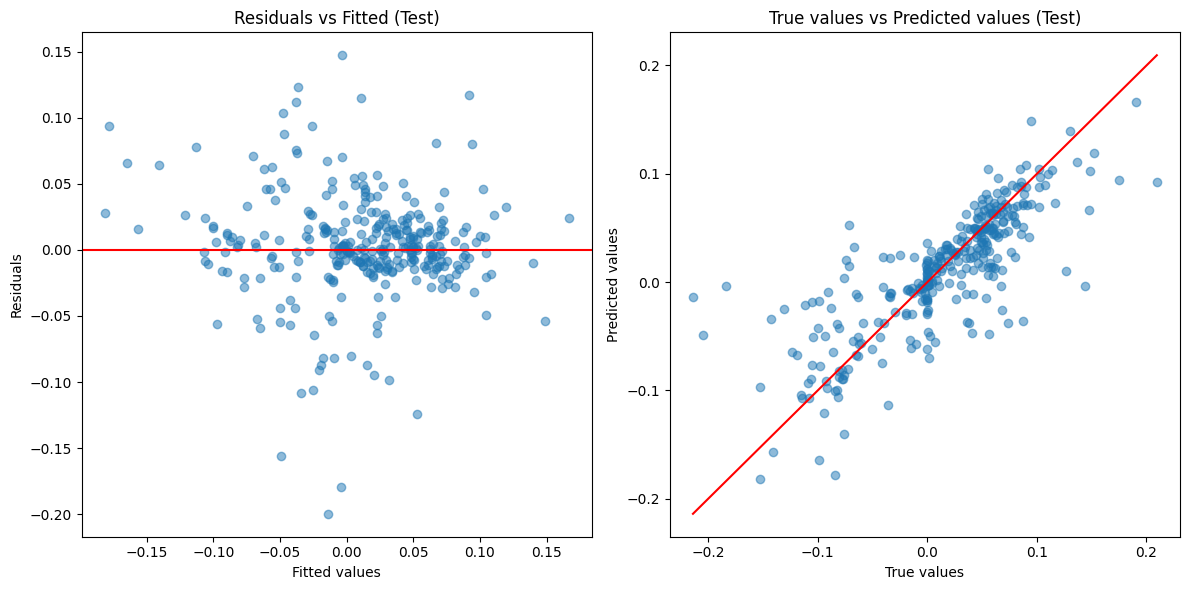

In [11]:
re.evaluate(best_xg_model, X_train, X_test, y_train, y_test)

bayesian library: hyperopt


squared error:
Max Error: 0.18125503895480155
Mean Absolute Error: 0.028771642226794094
Mean Squared Error: 0.0017289149240640868
Root Mean Squared Error: 0.04158022275149673
R-Squared: 0.35868886345039985


{'eta': 0.07, 'huber_slope': 0.09, 'max_depth': 5, 'n_estimators': 500}
Evaluation for XGBRegressor() (Train)
Max Error: 0.048238274460296604
Mean Absolute Error: 0.003856886990450304
Mean Squared Error: 3.481632221903628e-05
Root Mean Squared Error: 0.005900535756949218
R-Squared: 0.9938608154023577
Evaluation for XGBRegressor() (Test)
Max Error: 0.1993750269864869
Mean Absolute Error: 0.024952162466202625
Mean Squared Error: 0.0015649715404662831
Root Mean Squared Error: 0.039559721187924
R-Squared: 0.5316561316506809



{'eta': 0.07, 'huber_slope': 0.09, 'max_depth': 4, 'n_estimators': 600}
Evaluation for XGBRegressor() (Train)
Max Error: 0.23321921825931546
Mean Absolute Error: 0.007170784279910425
Mean Squared Error: 0.00014883213255127795
Root Mean Squared Error: 0.012199677559315981
R-Squared: 0.971830066233031

Evaluation for XGBRegressor() (Test)
Max Error: 0.1718971879561615
Mean Absolute Error: 0.025051471932839693
Mean Squared Error: 0.001505390657924575
Root Mean Squared Error: 0.03879936414330234
R-Squared: 0.5346230844883605


bayesian attempt 1:
{'colsample_bytree': 0.6315036640619673, 'eta': 0.0915037772437745, 'gamma': 0.00028034202077156095, 'huber_slope': 0.9015480623965334, 'max_depth': 11.0, 'min_child_weight': 7.0, 'reg_alpha': 0.43255254669909604, 'reg_lambda': 0.6474160288104589}

Max Error: 0.17040138080784797
Mean Absolute Error: 0.024417522579169088
Mean Squared Error: 0.0013420011327792654
Root Mean Squared Error: 0.036633333629077024
R-Squared: 0.5068430271171787

attempt 5 or 6:

{'colsample_bytree': 0.6609327156875529, 'eta': 0.06785747672769736, 'gamma': 0.0010918143411478261, 'huber_slope': 0.9194156689003281, 'max_depth': 9.0, 'min_child_weight': 7.0, 'reg_alpha': 0.35779564693698374, 'reg_lambda': 2.51437281780092}
Max Error: 0.16482401773402214
Mean Absolute Error: 0.024511157487374948
Mean Squared Error: 0.001394216388878761
Root Mean Squared Error: 0.03733920712707704
R-Squared: 0.44505220481916974

In [45]:
param_space = {
        'objective': 'reg:squarederror',
        'eta': hp.uniform('eta',0.001, 0.1),
        'max_depth': hp.quniform("max_depth", 3, 12, 1),
        #'huber_slope': hp.uniform('huber_slope', 0,1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,2),
        'reg_lambda' : hp.uniform('reg_lambda', 0,2),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 50)
    }

In [46]:
def objective(params):
    # Ensure parameters that should be integers are converted
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=params['eta'],
        max_depth=params['max_depth'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        n_estimators=params['n_estimators'],
        seed=0  # For reproducibility; note: in sklearn API, it's 'random_state', not 'seed'
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse = np.abs(scores.mean())
    
    return {'loss': rmse, 'status': STATUS_OK}

In [47]:
trials = Trials()
final_params = fmin(fn=objective,
            space=param_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)


100%|█████| 100/100 [01:13<00:00,  1.37trial/s, best loss: 0.058580374046344606]


In [ ]:
print(final_params)


final_params['max_depth'] = int(final_params['max_depth'])
final_params['n_estimators'] = int(final_params['n_estimators'])

best_model = xgb.XGBRegressor(**final_params)
best_model.fit(X_train_sel, y_train)
re.evaluate(best_model, X_train_sel, X_test_sel, y_train, y_test)

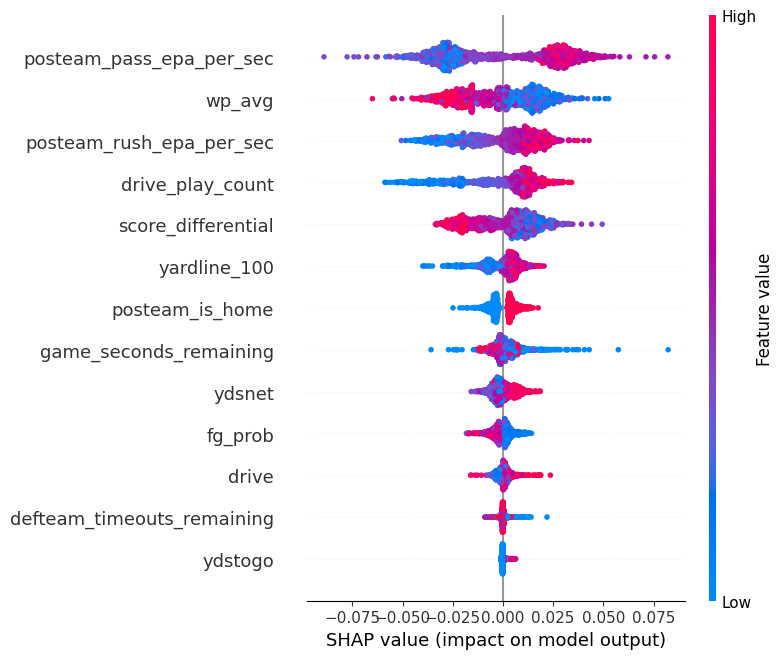

In [52]:
import shap


explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_sel)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train_sel)